In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import xgboost as xgb

## Part 1. Read data from csv file and preprocessing

Read the CSV file and observe the structure of the data. Since it only gives the timestamp and the speed of the corresponding time, so we need to do EDA(exploratory data analysis) and see which time data has a significant effect on the speed.

In [3]:
trafficFile = 'train.csv'
traffic = pd.read_csv(trafficFile, index_col="id", parse_dates=[1], dayfirst=True)
# traffic = traffic.drop(columns='id')
traffic.head()

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653


Based on EDA, we can discover that there is a big difference in the distribution of traffic speed between weekdays and weekends. Meanwhile, through the average velocity distribution, we can see that the velocity of identical months and each day within each month has a large fluctuation. So it's admirable to take month, date, day of week, and hour as the feature of the model, and also include the given timestamp as an analysis feature after normalization

In [4]:
traffic['hour'] = pd.to_datetime(traffic['date']).apply(lambda x: x.hour)
traffic['hour'] = traffic['hour']/23
traffic['weekday'] = pd.to_datetime(traffic['date']).apply(lambda x: x.dayofweek)
traffic['weekday'] = traffic['weekday']/6
traffic['month']=pd.to_datetime(traffic['date']).apply(lambda x:x.month)
traffic['month']=traffic['month']/12
traffic['day']=pd.to_datetime(traffic['date']).apply(lambda x:x.day)
traffic['day']=traffic['day']/30
max_time = max(traffic['date'])
min_time = min(traffic['date'])
traffic['time'] = (traffic['date']-min_time)/(max_time-min_time)

Set parameters for the dataset and split the original dataset into a training dataset and a testing one.

In [5]:
X = traffic[['time','weekday','hour','month','day']]
y = traffic['speed']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.001,random_state=0)

## Part2. Regression and Plot the result

In [7]:
def regression_method(model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    ResidualSquare = (result - y_test)**2
    RSS = sum(ResidualSquare)
    MSE = np.mean(ResidualSquare)
    num_regress = len(result)
    print(f'n={num_regress}')
    print(f'R^2={score}')
    print(f'MSE={MSE}')
    print(f'RSS={RSS}')
    # Draw line chart to show the difference between the predicting value and actual value
    plt.figure(figsize=(20,8),dpi=80)
    # Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('RandomForestRegression R^2: %f'%score)
    plt.legend()
    plt.show()
    return result,model

In [8]:
# Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
def scatter_plot(TureValues,PredictValues):
    # set the referenced 1:1 line
    xxx = [10,50]
    yyy = [10,50]
    plt.figure()
    plt.plot(xxx , yyy , c='0' , linewidth=1 , linestyle=':' , marker='.' , alpha=0.3)
    # scatter plot, whose x represents actural value and y represents predicting value
    plt.scatter(TureValues , PredictValues , s=20 , c='r' , edgecolors='k' , marker='o' , alpha=0.8)
    plt.xlim((10,50))
    plt.ylim((10,50))
    plt.title('RandomForestRegressionScatterPlot')
    plt.show()

In [9]:
my_model = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,
                            min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                           gamma=0,reg_alpha=0,reg_lambda=1,n_jobs=-1)

n=15
R^2=0.9385824885129685
MSE=9.42594714985498
RSS=141.38920724782471


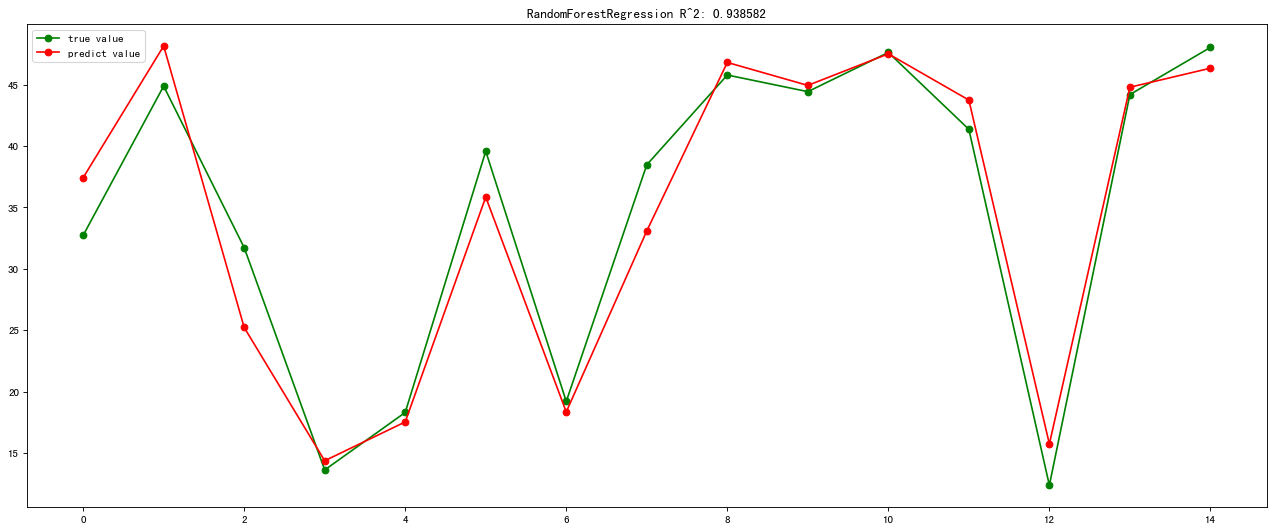

In [10]:
# get the predicting result, accuracy, and plot that represents difference between predicted value and actual value
y_pred,trained_model = regression_method(my_model)

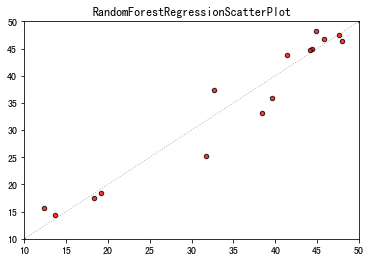

In [11]:
scatter_plot(y_test,y_pred)

## Part3. Adjust the parameters of the model and reach an admirable result

Due to the limitation of computer performance, we only adjust parameters one by one or set some related parameters as a group to adjust

### (1) n_estimator

Number of gradient boosted trees.  Equivalent to number of boosting rounds. The larger the n_estimator, the better performance of xgboost Regressor, but after certain round, increasing this parameter will not increase the performance significantly

In [15]:
cv_params = {'n_estimators': range(100,301,20)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized_GBM.fit(x_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('best score each round:{0}'.format(evalute_result))
print('best parameter：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:   15.1s finished


best score each round:{'mean_fit_time': array([1.37403932, 0.88802571, 0.90317788, 1.02399321, 1.15450072,
       1.35179725, 1.43648095, 1.51692638, 1.67056689, 1.76390133,
       1.83899446]), 'std_fit_time': array([0.16634034, 0.29612798, 0.01362017, 0.01233082, 0.00848213,
       0.03536845, 0.02563144, 0.03468464, 0.0391157 , 0.0266606 ,
       0.04496315]), 'mean_score_time': array([0.01859131, 0.02178249, 0.02199059, 0.02761445, 0.03194604,
       0.03702035, 0.03941064, 0.04501967, 0.05064406, 0.05757928,
       0.05693588]), 'std_score_time': array([0.00291651, 0.00288151, 0.00101407, 0.00142888, 0.00291227,
       0.00244983, 0.00186724, 0.00172912, 0.00197378, 0.00247095,
       0.00317373]), 'param_n_estimators': masked_array(data=[100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimator

In [16]:
cv_params = {'n_estimators': range(180,221,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 41 candidates, totalling 205 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   42.5s
[Parallel(n_jobs=6)]: Done 205 out of 205 | elapsed:   46.2s finished


({'mean_fit_time': array([1.21117702, 1.19944172, 1.17058525, 1.19192262, 1.21155715,
         1.19689498, 1.17888775, 1.21025381, 1.21519899, 1.23576937,
         1.23670173, 1.23864079, 1.25035782, 1.22933173, 1.26994324,
         1.28239989, 1.31603026, 1.29427042, 1.27094207, 1.27733917,
         1.28969669, 1.36950521, 1.37658219, 1.38927541, 1.34341106,
         1.35674486, 1.31970916, 1.34927754, 1.32342858, 1.35914111,
         1.33455243, 1.36174521, 1.36704822, 1.37035189, 1.38779588,
         1.43332763, 1.39564795, 1.3877564 , 1.42114067, 1.42462835,
         1.34091992]),
  'std_fit_time': array([0.04188342, 0.03293038, 0.0224992 , 0.02897411, 0.0522421 ,
         0.02980579, 0.00773375, 0.02172576, 0.02198376, 0.03999393,
         0.01798617, 0.0221738 , 0.04271964, 0.01714931, 0.04315283,
         0.01439304, 0.05896522, 0.03269659, 0.04176286, 0.01884425,
         0.01693949, 0.04718671, 0.04451208, 0.02595429, 0.03036933,
         0.04104253, 0.02631758, 0.01905539, 0.

### (2) max_depth && min_child_weight

'max_depth' is the maximum depth of a tree, 'min_child_weight' defines the minimum sum of weights of all observations required in a child. Both works for avoiding overfitting, the smaller the depth, the higher the min_child_weight, the better model generalization.

In [17]:
cv_params = {'max_depth': range(4,15,2), 'min_child_weight': range(1,7,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:   34.3s finished


({'mean_fit_time': array([0.58054786, 0.57685676, 0.57058172, 0.55646   , 0.54927139,
         0.53434782, 0.74963927, 0.73889608, 0.73847103, 0.73384013,
         0.73263841, 0.7227602 , 0.96764421, 0.95138359, 0.94492536,
         0.93452182, 0.93757815, 0.94057517, 1.18473263, 1.166506  ,
         1.15306811, 1.13933492, 1.14196444, 1.11934061, 1.53946614,
         1.50992336, 1.47775126, 1.51394591, 1.39236774, 1.43753896,
         1.82183948, 1.75645938, 1.74065685, 1.74237843, 1.71735578,
         1.55679998]),
  'std_fit_time': array([0.01876615, 0.01682903, 0.01024998, 0.00855396, 0.01422932,
         0.00411194, 0.02247581, 0.0188545 , 0.02578112, 0.00836269,
         0.01621288, 0.01451737, 0.03855628, 0.02674991, 0.03476955,
         0.02769315, 0.02500484, 0.00671278, 0.01674877, 0.01549751,
         0.02214216, 0.0359302 , 0.01763439, 0.01559613, 0.0607601 ,
         0.05062254, 0.03384374, 0.04686292, 0.00636727, 0.04830063,
         0.04101161, 0.05255493, 0.04780793, 0.

In [18]:
cv_params = {'max_depth': range(8,13,1), 'min_child_weight': [1.0,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   38.3s
[Parallel(n_jobs=6)]: Done 225 out of 225 | elapsed:   47.1s finished


({'mean_fit_time': array([0.99377384, 1.04159894, 1.01621284, 0.96074858, 0.95819063,
         0.95697374, 0.93646674, 0.965907  , 0.95928993, 1.10360374,
         1.11784983, 1.15387502, 1.19587388, 1.10145884, 1.10214262,
         1.09801979, 1.11260762, 1.07509661, 1.24248514, 1.21094246,
         1.20360904, 1.20511355, 1.22246137, 1.20119734, 1.19494767,
         1.19541492, 1.21666141, 1.34835954, 1.31966906, 1.286163  ,
         1.3123261 , 1.30145025, 1.29771709, 1.27098675, 1.2875433 ,
         1.27863216, 1.43403859, 1.42166686, 1.44510584, 1.42127628,
         1.4401216 , 1.43873482, 1.41979127, 1.41093831, 1.3036099 ]),
  'std_fit_time': array([0.00830633, 0.06250094, 0.04107488, 0.02143688, 0.02006433,
         0.01175543, 0.02701172, 0.02396526, 0.01401872, 0.02169278,
         0.04338009, 0.04474862, 0.04450212, 0.06469714, 0.0480146 ,
         0.02726654, 0.04072507, 0.04079403, 0.05767499, 0.03698749,
         0.02308209, 0.03049635, 0.02135439, 0.03600747, 0.01983304,

In [20]:
cv_params = {'max_depth': range(8,12,1), 'min_child_weight': [0.7,0.8,0.9,1.0,1.1,1.2,1.3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done 140 out of 140 | elapsed:   30.3s finished


({'mean_fit_time': array([1.83064303, 1.11398578, 0.9402916 , 0.93167062, 0.93555818,
         0.93894916, 0.96610799, 1.08351765, 1.07019138, 1.06805959,
         1.068361  , 1.05165496, 1.08239579, 1.09313207, 1.19517059,
         1.18508167, 1.16970196, 1.1707624 , 1.18977327, 1.17874045,
         1.1809526 , 1.29856582, 1.3137886 , 1.3225697 , 1.321942  ,
         1.30097022, 1.32189188, 1.21443634]),
  'std_fit_time': array([0.01470915, 0.3230812 , 0.0159845 , 0.02695646, 0.02948556,
         0.01393176, 0.02471502, 0.0225072 , 0.03467796, 0.01695022,
         0.00510595, 0.01819113, 0.01925585, 0.02382192, 0.01819917,
         0.04074307, 0.01119615, 0.01583687, 0.02262383, 0.02411877,
         0.03304615, 0.0137997 , 0.03650872, 0.05017325, 0.05119552,
         0.02758976, 0.02981795, 0.12105367]),
  'mean_score_time': array([0.02354684, 0.02079353, 0.02146034, 0.02220788, 0.02165322,
         0.02173185, 0.02138124, 0.02761064, 0.02700405, 0.02680163,
         0.02909832, 0.027

So the best max_depth and min_child_weight is 9 and 1.0

### (3) gamma

Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

In [21]:
cv_params = {'gamma': [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:    8.4s finished


({'mean_fit_time': array([1.07127662, 1.11271811, 1.07011251, 1.0587584 , 1.08116231,
         1.05110674, 1.07134209, 1.05947318, 0.90556316]),
  'std_fit_time': array([0.01950195, 0.03659545, 0.03988624, 0.04958471, 0.01857945,
         0.02413657, 0.01505225, 0.01410371, 0.1213584 ]),
  'mean_score_time': array([0.03041315, 0.04256821, 0.02904296, 0.02466197, 0.02519779,
         0.0262342 , 0.02692327, 0.02496829, 0.02276306]),
  'std_score_time': array([0.00172575, 0.01046531, 0.00157565, 0.00058576, 0.00081016,
         0.00165975, 0.00295938, 0.00040172, 0.00286957]),
  'param_gamma': masked_array(data=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0},
   {'gamma': 0.05},
   {'gamma': 0.1},
   {'gamma': 0.15},
   {'gamma': 0.2},
   {'gamma': 0.25},
   {'gamma': 0.3},
   {'gamma': 0.35},
   {'gamma

So the best gamma is 0.2

### (4) subsample && colsample_bytree

Also aiming at avoiding overfitting. 'subsample' denotes the fraction of observations to be randomly samples for each tree. 'colsample_bytree' denotes the fraction of columns to be randomly samples for each tree, as the nuumber of feature selected for this model is small, usually we keep 'colsample_bytree' to be one.

In [22]:
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9,1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9,1.0]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done 125 out of 125 | elapsed:   23.3s finished


({'mean_fit_time': array([1.06845822, 1.02262182, 1.0286448 , 1.06378813, 0.95782356,
         1.10978093, 1.04393635, 1.09970303, 1.06539783, 0.96130648,
         1.18411484, 1.12346635, 1.07737112, 1.06396623, 0.97891965,
         1.12098517, 1.13283477, 1.06175637, 1.04966969, 0.94433408,
         1.25338917, 1.20033536, 1.16544504, 1.14030309, 0.98308816]),
  'std_fit_time': array([0.04574028, 0.05151354, 0.04002053, 0.033191  , 0.02350153,
         0.03360505, 0.04864744, 0.03531851, 0.04409362, 0.02611005,
         0.03049005, 0.02152479, 0.03120644, 0.02065464, 0.04071559,
         0.03482735, 0.01794122, 0.03702342, 0.00686051, 0.01186137,
         0.02149144, 0.01355629, 0.04194155, 0.03510305, 0.06449676]),
  'mean_score_time': array([0.02992773, 0.02766891, 0.02776093, 0.0270648 , 0.0257761 ,
         0.03148828, 0.0314189 , 0.03182702, 0.02743068, 0.02595873,
         0.03018074, 0.02601113, 0.02489591, 0.02340722, 0.02284636,
         0.02712941, 0.02818065, 0.02624664, 0.

In [25]:
cv_params = {'subsample': [0.77,0.78,0.79,0.8,0.81,0.82], 'colsample_bytree': [0.77,0.78,0.79,0.8,0.81,0.82]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:   32.6s finished


({'mean_fit_time': array([1.00675955, 0.99937263, 0.99757628, 1.01741714, 1.01151743,
         1.02055893, 0.99028826, 1.07215323, 1.03978915, 1.01469588,
         1.00240579, 1.00737729, 1.0523519 , 1.02759557, 1.01962471,
         1.0109735 , 0.9891417 , 0.98448386, 1.07021365, 1.09059601,
         1.06861219, 1.07924709, 1.14233747, 1.15168586, 1.09976211,
         1.0798461 , 1.08303242, 1.09553051, 1.08597398, 1.10143757,
         1.09538984, 1.10550041, 1.09491591, 1.08904209, 1.0921247 ,
         1.08445992]),
  'std_fit_time': array([0.03519337, 0.00636402, 0.01897081, 0.01379741, 0.03021743,
         0.02549568, 0.01518092, 0.03860066, 0.02236916, 0.02468361,
         0.01610791, 0.02209265, 0.04007717, 0.01249061, 0.02073029,
         0.03187622, 0.00957049, 0.01584482, 0.03375906, 0.02070683,
         0.02463573, 0.02811258, 0.02830295, 0.03198083, 0.01732186,
         0.02426502, 0.02251737, 0.03963634, 0.01290471, 0.04754296,
         0.04378775, 0.02667763, 0.02326926, 0.

So the best sub_sample, colsample_bytree is 0.8 and 0.8

### (5) reg_alpha && reg_lambda

reg_alpha is the l1 regularization term on weight, while reg_lambda is the l2 regularization ter on weights. Also work as ways to avoid overfitting.

In [26]:
cv_params = {'reg_alpha': [0.05,0.1,0.5,1,1.5,2,3], 'reg_lambda': [0.05,0.1,0.5,1,1.5,2,3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done 245 out of 245 | elapsed:   45.6s finished


({'mean_fit_time': array([1.1018065 , 1.09318318, 1.10257916, 1.10828652, 1.0846622 ,
         1.14939976, 1.09645586, 1.08488874, 1.08250918, 1.07849541,
         1.06187773, 1.07283497, 1.06738071, 1.06108685, 1.11167097,
         1.08622823, 1.0861764 , 1.07712102, 1.02050195, 1.03972802,
         1.06221128, 1.06831913, 1.08295207, 1.09862218, 1.06465464,
         1.08616829, 1.11908855, 1.09090891, 1.10003037, 1.0834764 ,
         1.08018079, 1.09118023, 1.0881175 , 1.08024478, 1.0606225 ,
         1.09425058, 1.09762173, 1.07679791, 1.08193269, 1.06876616,
         1.06376462, 1.06337605, 1.09567451, 1.0954186 , 1.09627209,
         1.08984747, 1.09830408, 1.08218899, 1.03749161]),
  'std_fit_time': array([0.05184672, 0.016248  , 0.01908407, 0.03725001, 0.03161675,
         0.02423259, 0.02926907, 0.02738948, 0.01597519, 0.03358841,
         0.01520032, 0.01285558, 0.01443307, 0.03192916, 0.0297478 ,
         0.03028973, 0.03171044, 0.02996077, 0.01862181, 0.02172516,
         0.

In [27]:
cv_params = {'reg_alpha': [2.5,3,3.5,4,4.5,5], 'reg_lambda': [0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:   39.8s finished


({'mean_fit_time': array([1.10749354, 1.12976241, 1.08472614, 1.06867175, 1.07512865,
         1.07300096, 1.07544508, 1.08414354, 1.07354422, 1.12945347,
         1.15076623, 1.06803946, 1.07628193, 1.07569733, 1.0864882 ,
         1.07908874, 1.09034081, 1.12021828, 1.18571458, 1.12145581,
         1.12832623, 1.14904466, 1.1177176 , 1.11237116, 1.13888822,
         1.09569731, 1.10259361, 1.12136726, 1.15199094, 1.09761801,
         1.08644371, 1.09274507, 1.10695305, 1.09877424, 1.10528159,
         1.09401197, 1.10105696, 1.09310122, 1.09560385, 1.10259786,
         1.07119365, 1.07272077]),
  'std_fit_time': array([0.01129202, 0.02951776, 0.03017482, 0.02446573, 0.01854457,
         0.01899249, 0.02766083, 0.02212754, 0.01515947, 0.04407307,
         0.06067978, 0.00851005, 0.01542446, 0.01426233, 0.06180539,
         0.0235526 , 0.02189513, 0.03407814, 0.02779111, 0.02406766,
         0.01674612, 0.02756469, 0.0306402 , 0.00940861, 0.02869487,
         0.00543816, 0.02036152, 0.

In [28]:
cv_params = {'reg_alpha': [3.3,3.4,3.5,3.6,3.7,3.8], 'reg_lambda': [0.34,0.36,0.38,0.4,0.42,0.44,0.46]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:   39.4s finished


({'mean_fit_time': array([1.09028559, 1.07583246, 1.07020035, 1.08459663, 1.09538927,
         1.07187638, 1.09034424, 1.10711169, 1.10607576, 1.09607663,
         1.08506227, 1.09788532, 1.12995028, 1.16377835, 1.10736856,
         1.08152757, 1.07599912, 1.07397909, 1.0814599 , 1.09383297,
         1.10324373, 1.08261695, 1.07177668, 1.06097121, 1.07570052,
         1.06878495, 1.1078845 , 1.07815428, 1.07529826, 1.08958464,
         1.08054142, 1.118121  , 1.1220324 , 1.10078487, 1.09597998,
         1.07145638, 1.06762667, 1.11005812, 1.07834239, 1.0988893 ,
         1.11989889, 1.09031887]),
  'std_fit_time': array([0.01506826, 0.01383748, 0.01628961, 0.01921882, 0.01317738,
         0.01283182, 0.02824739, 0.01417561, 0.01875784, 0.02163674,
         0.02381102, 0.0139758 , 0.03626047, 0.02357006, 0.03126898,
         0.03806184, 0.01237631, 0.02103481, 0.01202124, 0.03032387,
         0.01389589, 0.02167894, 0.01394365, 0.02071717, 0.00657349,
         0.01300703, 0.03530109, 0.

In [29]:
cv_params = {'reg_alpha': [3.67,3.68,3.69,3.7,3.71,3.72,3.73], 'reg_lambda': [0.34,0.35,0.36,0.37,0.38]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 175 out of 175 | elapsed:   33.2s finished


({'mean_fit_time': array([1.08486829, 1.07803636, 1.06954288, 1.08952074, 1.08265767,
         1.11109304, 1.11369629, 1.09859076, 1.10307002, 1.10448418,
         1.13876233, 1.10003328, 1.11391382, 1.10843606, 1.10300226,
         1.07884545, 1.0664959 , 1.10820918, 1.09218736, 1.0736712 ,
         1.08705797, 1.11857104, 1.10828981, 1.0943171 , 1.08134856,
         1.07149868, 1.07413435, 1.10325222, 1.07945189, 1.06859245,
         1.09131589, 1.07241268, 1.09276533, 1.09440804, 1.01857314]),
  'std_fit_time': array([0.01519504, 0.01769226, 0.02130384, 0.02066887, 0.02079046,
         0.01840563, 0.0663344 , 0.03072063, 0.02051421, 0.00680645,
         0.01486079, 0.02391523, 0.02798562, 0.02829226, 0.02023313,
         0.00848298, 0.02006892, 0.02295848, 0.01469359, 0.02129385,
         0.02065233, 0.05736625, 0.02088207, 0.0138625 , 0.03621235,
         0.02022754, 0.02071545, 0.02293934, 0.02499039, 0.02230253,
         0.02951991, 0.01785345, 0.02964351, 0.05097644, 0.13105341]

So the best reg_alpha and reg_lambda is 3.7 and 0.36

### (6) learning_rate

A higher learning rate helps the model converge quicker, but it may affect the precision, so we need to check whether lowering the learning rate may lead to a better result.

In [30]:
cv_params = {'learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]}
other_params = {'learning_rate': 0.1, 'n_estimators': 184, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 3.7, 'reg_lambda': 0.36,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=6)
optimized.fit(x_train, y_train)
optimized.cv_results_, optimized.best_params_, optimized.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:   10.9s finished


({'mean_fit_time': array([1.15139894, 1.13105311, 1.12323208, 1.10072818, 1.09583149,
         1.0817915 , 1.14864974, 1.09639721, 1.10291991, 1.12104635,
         1.0433383 ]),
  'std_fit_time': array([0.04366448, 0.02619191, 0.0397912 , 0.00914023, 0.00985798,
         0.01383648, 0.05980705, 0.02265544, 0.02518361, 0.02673168,
         0.12043685]),
  'mean_score_time': array([0.02633247, 0.027356  , 0.02655902, 0.02826142, 0.02819324,
         0.02619224, 0.02855349, 0.02898726, 0.02841635, 0.02821279,
         0.02547045]),
  'std_score_time': array([0.0007451 , 0.00212086, 0.00140125, 0.00295483, 0.0029886 ,
         0.00107209, 0.00260399, 0.00200476, 0.00308025, 0.00188457,
         0.00260952]),
  'param_learning_rate': masked_array(data=[0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                     0.14, 0.15],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
          

## Part4. Apply all adjustments and see the improvement in performance

In [15]:
xgb_processed = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=9,
                            min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                           gamma=0.2,reg_alpha=3.7,reg_lambda=0.36,n_jobs=-1)

n=15
R^2=0.953294570283097
MSE=7.168035654061826
RSS=107.52053481092739


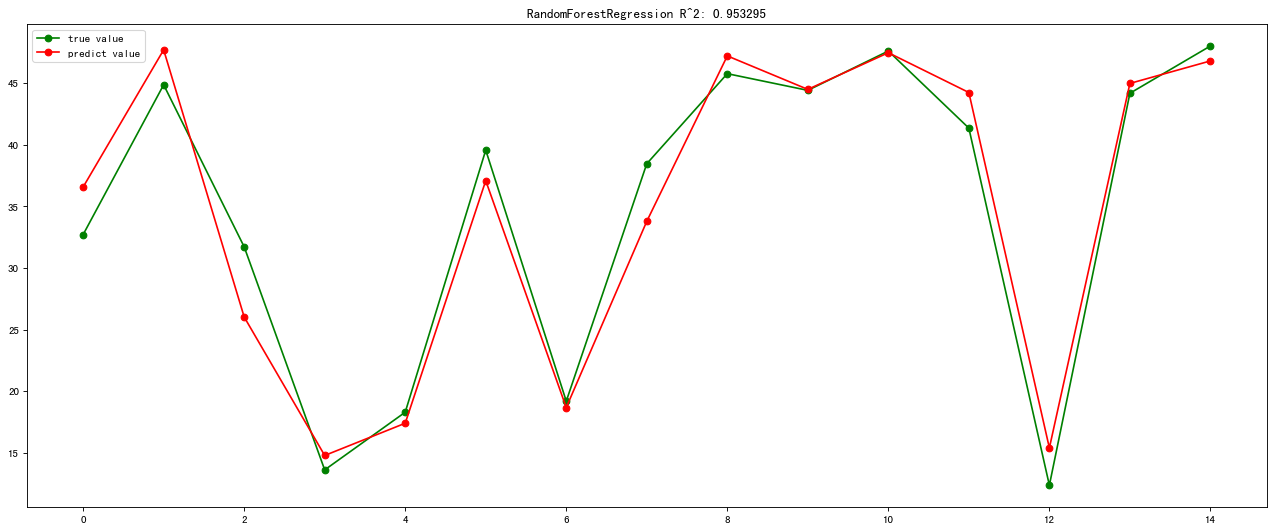

In [16]:
# get the trained model and apply it to data in 'test.csv'
y_pred,trained_model = regression_method(xgb_processed)

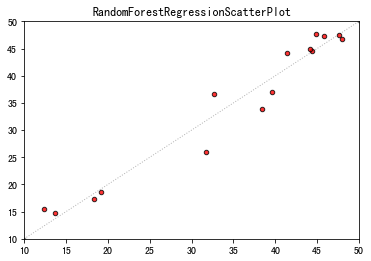

In [17]:
scatter_plot(y_test,y_pred)  #生成散点图

## Part 5. Read test data and get prediction result

In [18]:
data_test = pd.read_csv("test.csv", index_col='id', parse_dates=[1], dayfirst=True)
# data_test['datetime'] = pd.to_datetime(data_test['date'])
data_test['hour'] = pd.to_datetime(data_test['date']).apply(lambda x: x.hour)
data_test['hour'] = data_test['hour']/23
data_test['weekday'] = pd.to_datetime(data_test['date']).apply(lambda x: x.dayofweek)
data_test['weekday'] = data_test['weekday']/6
data_test['month'] = pd.to_datetime(data_test['date']).apply(lambda x:x.month)
data_test['month'] = data_test['month']/12
data_test['day'] = pd.to_datetime(data_test['date']).apply(lambda x:x.day)
data_test['day'] = data_test['day']/30
data_test['time'] = (data_test['date']-min_time)/(max_time-min_time)
data_test.head()

,date,hour,weekday,month,day,time
id,,,,,,
0,2018-01-01 02:00:00,0.086957,0.0,0.083333,0.033333,0.500228
1,2018-01-01 05:00:00,0.217391,0.0,0.083333,0.033333,0.500400
2,2018-01-01 07:00:00,0.304348,0.0,0.083333,0.033333,0.500514
3,2018-01-01 08:00:00,0.347826,0.0,0.083333,0.033333,0.500571
4,2018-01-01 10:00:00,0.434783,0.0,0.083333,0.033333,0.500685


In [19]:
predict_x = data_test[['time','weekday','hour','month','day']]
predict_x.shape

(3504, 5)

In [20]:
y = trained_model.predict(predict_x)

## Part6. Save results in the required form

In [21]:
y = y.reshape(-1,1)

index = np.arange(len(y))
index = index.reshape(-1,1)

df = pd.DataFrame(dict(date=data_test['date'].ravel(), id=index.ravel()))
df.drop(['date'], axis=1, inplace=True)
df = pd.DataFrame(dict(id=df['id'].ravel(), speed=y.ravel()))
df

,id,speed
0,0,48.329479
1,1,48.160076
2,2,36.044113
3,3,29.883053
4,4,37.772198
...,...,...
3499,3499,13.594538
3500,3500,22.247801
3501,3501,44.154335
3502,3502,39.579090


In [23]:
df.to_csv("xgboost_model2_pred.csv",index=False)